# Summary

* There is not consensus on the feature associating the largest variance between feature sets.
* The general amount of feature variance increases with reduced amount of artifacts in the images through slice removal.

In [58]:
import sys
sys.path.append('./../prepping/')

import numpy as np
import pandas as pd

from scipy import linalg
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.spatial import distance

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

# Original Images Features

In [2]:
_y_orig = pd.read_csv('./../../data_source/to_analysis/original_images/dfs_original_images.csv', index_col=0)
y_orig = np.squeeze(_y_orig.values)

X_orig = pd.read_csv('./../../data_source/to_analysis/original_images/all_features_original_images.csv',index_col=0)
X_orig.head()

,Age,Years Smoking,Naxogin Days,Sex_M,ICD-10_C02,ICD-10_C03,ICD-10_C04,ICD-10_C05,ICD-10_C06,ICD-10_C09,...,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
2,60.832877,0.000000,39.0,1,0,0,0,0,0,1,...,47916.617451,0.094457,0.178525,0.358043,6.057050,25.566977,101.349019,21.616549,7.384,124.870726
4,49.906849,4.786027,33.0,0,0,0,0,0,0,1,...,19579.702532,0.070352,0.125185,0.238295,6.021110,27.043416,112.933552,15.296275,3.406,41.554406
5,54.238356,0.000000,42.0,0,0,0,0,0,0,1,...,14251.207526,0.054852,0.099392,0.191019,2.465487,10.711840,44.417785,14.473272,7.934,86.228420
8,54.687671,18.343836,0.0,1,0,0,0,0,0,0,...,7766.277251,0.024052,0.038650,0.070961,0.557200,2.723527,11.765552,10.510859,26.926,205.413389
10,61.728767,0.000000,35.0,1,0,0,0,0,0,0,...,2229.551107,0.029594,0.044499,0.082635,0.583427,3.013379,12.730022,7.213190,6.041,32.103770


In [3]:
X_orig.shape

(198, 513)

In [4]:
X_orig_shape = X_orig.filter(regex='shape')
X_orig_PET = X_orig.filter(regex='PET')
X_orig_CT = X_orig.filter(regex='CT')

X_orig_shape.shape, X_orig_PET.shape, X_orig_CT.shape

((198, 14), (198, 228), (198, 229))

In [5]:
scaler = StandardScaler()

X_orig_shape_std = scaler.fit_transform(X_orig_shape)
X_orig_PET_std = scaler.fit_transform(X_orig_PET)
X_orig_CT_std = scaler.fit_transform(X_orig_CT)

X_orig_shape_std.shape, X_orig_PET_std.shape, X_orig_CT_std.shape

((198, 14), (198, 228), (198, 229))

In [6]:
for col in X_orig_shape:
    print(col)

original_shape_Elongation
original_shape_Flatness
original_shape_LeastAxisLength
original_shape_MajorAxisLength
original_shape_Maximum2DDiameterColumn
original_shape_Maximum2DDiameterRow
original_shape_Maximum2DDiameterSlice
original_shape_Maximum3DDiameter
original_shape_MeshVolume
original_shape_MinorAxisLength
original_shape_Sphericity
original_shape_SurfaceArea
original_shape_SurfaceVolumeRatio
original_shape_VoxelVolume


"plt.savefig(\n    './../../figures/radiomic_features/scatter_radiom_orig.png', \n    bbox_inches='tight',\n    transparent=True,\n    dpi=100, \n)"

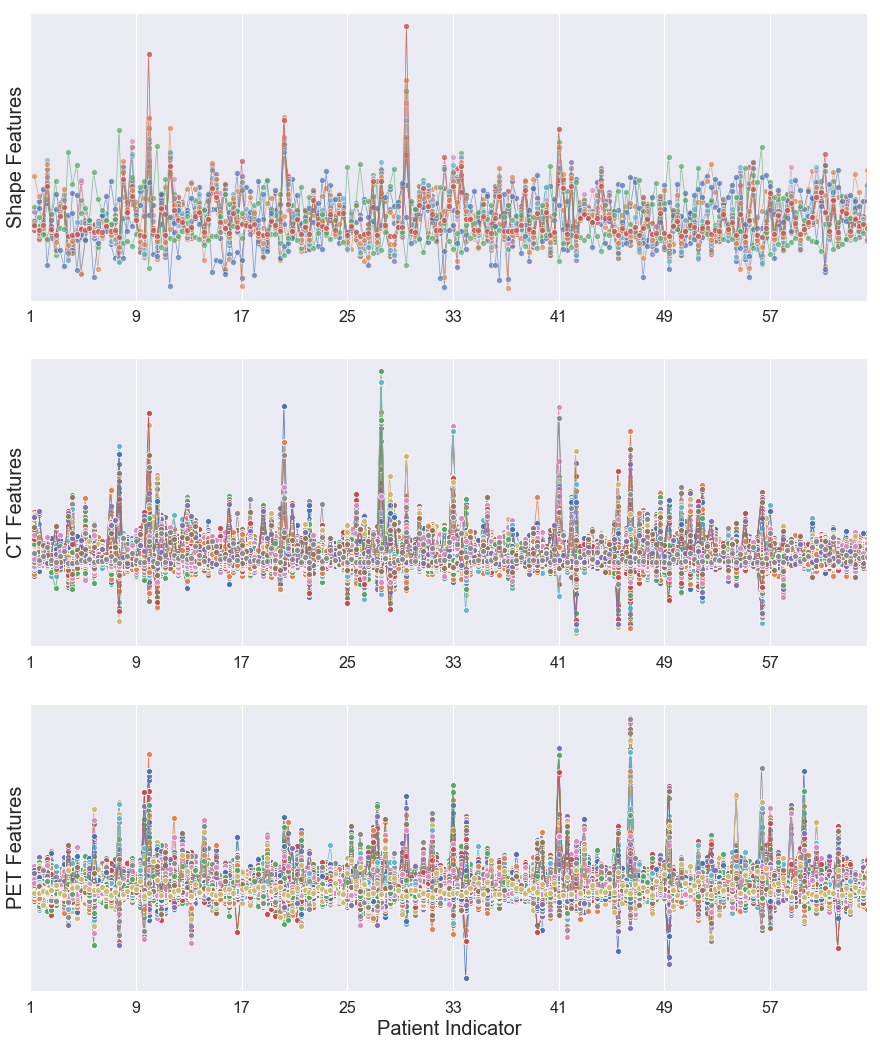

In [7]:
x_coords = np.arange(1, np.size(y_orig) + 1)

sns.set()
fig, axes = plt.subplots(nrows=3, figsize=(15, 18))

for shape_col in X_orig_shape_std.T:
    sns.lineplot(
        x=x_coords,
        y=shape_col,
        marker='o',
        #hue=_hue,
        legend=False,
        ax=axes[0],
        alpha=0.7
    )
for PET_col in X_orig_PET_std.T:
    sns.lineplot(
        x=x_coords,
        y=PET_col,
        marker='o',
        #hue=_hue,
        legend=False,
        ax=axes[1]
    )
for CT_col in X_orig_CT_std.T:
    sns.lineplot(
        x=x_coords,
        y=CT_col,
        marker='o',
        #hue=_hue,
        legend=False,
        ax=axes[2]
    )
titles = ['Shape Features', 'CT Features', 'PET Features']
for num, axis in enumerate(axes.ravel()):
    axis.set_ylabel(titles[num], fontsize=20)
    axis.set_yticks([])
    axis.set_xlim([0, 198])
    axis.set_xticklabels(np.arange(1, 198, 8), fontsize=16)
    
    for l in axis.lines:
        plt.setp(l, linewidth=0.7)
    
plt.xlabel('Patient Indicator', fontsize=20)
"""plt.savefig(
    './../../figures/radiomic_features/scatter_radiom_orig.png', 
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)"""

In [8]:
# The two shape features varying the most among patients are the original_shape_VoxelVolume and
# original_shape_MeshVolume.
pd.DataFrame(X_orig_shape_std.max(axis=0), index=X_orig_shape.columns)

,0
original_shape_Elongation,1.805827
original_shape_Flatness,2.599839
original_shape_LeastAxisLength,5.056585
original_shape_MajorAxisLength,3.042810
original_shape_Maximum2DDiameterColumn,3.207078
original_shape_Maximum2DDiameterRow,3.171995
original_shape_Maximum2DDiameterSlice,4.573853
original_shape_Maximum3DDiameter,3.240948
original_shape_MeshVolume,7.653328
original_shape_MinorAxisLength,3.907555


In [9]:
# Some of the PET features varying the most across patients are the 
# PET_original_glszm_ZoneVariance, PET_original_firstorder_Energy
max_pet_feats = pd.DataFrame(X_orig_PET_std.max(axis=0), index=X_orig_PET.columns)
for i in max_pet_feats.T:
    val = max_pet_feats.loc[i, :].values
    if val > 11:
        print(i, val)

PET_original_firstorder_Energy [11.04279483]
PET_original_firstorder_TotalEnergy [11.04279483]
PET_original_glszm_LargeAreaEmphasis_64bins [12.66264598]
PET_original_glszm_LargeAreaEmphasis_128bins [12.82151789]
PET_original_glszm_LargeAreaHighGrayLevelEmphasis_32bins [11.08684831]
PET_original_glszm_LargeAreaHighGrayLevelEmphasis_128bins [13.72940331]
PET_original_glszm_ZoneVariance_64bins [12.81152757]
PET_original_glszm_ZoneVariance_128bins [12.9035844]


In [10]:
max_ct_feats = pd.DataFrame(X_orig_CT_std.max(axis=0), index=X_orig_CT.columns)
for i in max_ct_feats.T:
    val = max_ct_feats.loc[i, :].values
    if val > 11:
        print(i, val)

CT_original_gldm_LargeDependenceLowGrayLevelEmphasis_32bins [12.36233741]
CT_original_gldm_LargeDependenceLowGrayLevelEmphasis_64bins [12.80123131]
CT_original_gldm_LargeDependenceLowGrayLevelEmphasis_128bins [13.30140076]
CT_original_gldm_LowGrayLevelEmphasis_32bins [11.28351977]
CT_original_glrlm_LongRunLowGrayLevelEmphasis_32bins [12.04249529]
CT_original_glrlm_LongRunLowGrayLevelEmphasis_64bins [13.22949973]
CT_original_glrlm_LongRunLowGrayLevelEmphasis_128bins [13.09931758]
CT_original_glrlm_LowGrayLevelRunEmphasis_32bins [11.42159558]


# Feature Variance Original Images

In [17]:
def format_feature_labels(labels):
    """Process raw feature labels."""
    prep_labels = []
    for label in labels:
        #print(label)
        comps = label.split('_')
        if len(comps) == 1:
            prep_labels.append(label.title())
        elif len(comps) == 2:
            new_label = f'{comps[0]}: {comps[1]}'
            prep_labels.append(new_label)
        elif len(comps) == 3:
            filter_type, feature_type, name = comps
            if len(name) > 15:
                new_label = '{}'.format(name)
            else:
                new_label = '{}'.format(name)
            prep_labels.append(new_label)
        elif len(comps) == 4:
            image_type, filter_type, feature_type, name = comps
            if len(name) > 15:
                new_label = f'{name}'
            else:
                new_label = f'{name}'
            prep_labels.append(new_label)
        elif len(comps) == 5:
            image_type, _, _, name, _ = comps
            if len(name) > 15:
                new_label = f'{name}'
            else:
                new_label = f'{name}'
            prep_labels.append(new_label)
        else:
            raise ValueError('Label more than 5 comps!')
            
    return prep_labels

In [15]:
# Original images.
X_orig_no_clinical = pd.concat((X_orig_shape, X_orig_PET, X_orig_CT), axis=1)
X_orig_no_clinical = X_orig_no_clinical / X_orig_no_clinical.max(axis=0)

X_orig_vars = X_orig_no_clinical.var()
X_orig_max_var = X_orig_vars.max()
print(X_orig_max_var)
list(X_orig_no_clinical.columns[np.where(X_orig_max_var == X_orig_vars)])

0.19838359087431504


['CT_original_firstorder_Skewness']

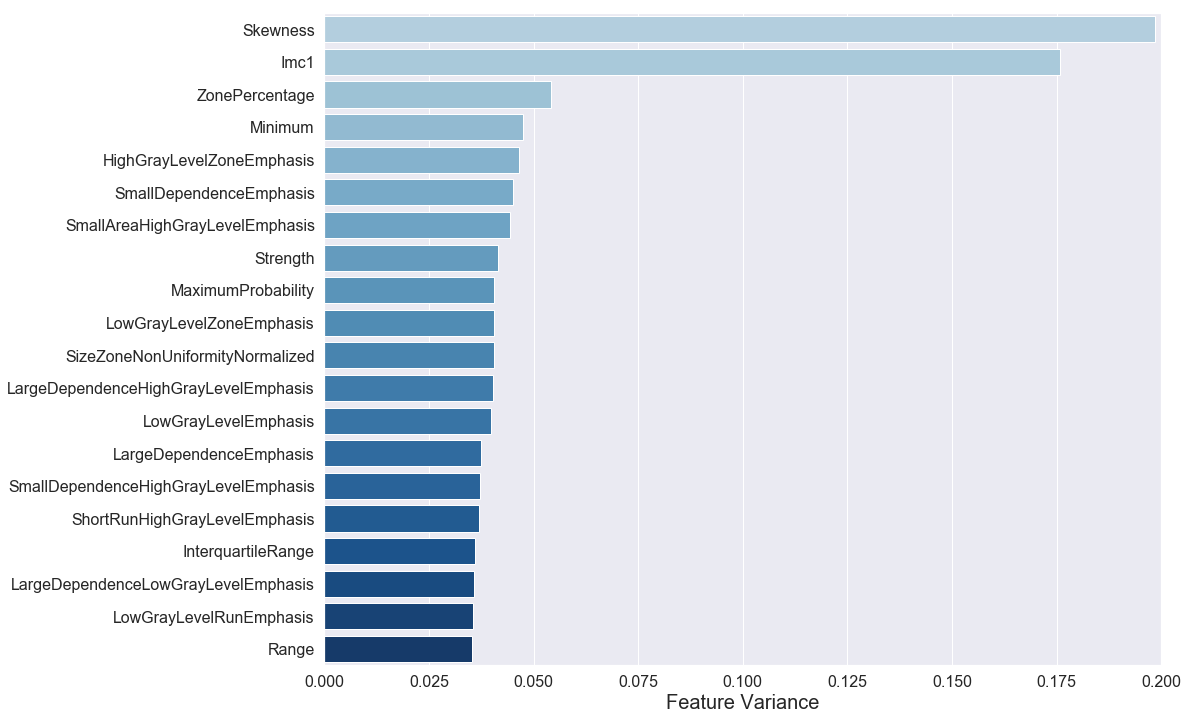

In [18]:
X_orig_vars_sorted = X_orig_vars.sort_values(inplace=False, ascending=False)

orig_vars = {}
for idx, val in zip(X_orig_vars_sorted.index, X_orig_vars_sorted):
    name = format_feature_labels([idx])[0]
    if name not in orig_vars.keys():
        orig_vars[name] = val
        
n = 20
x_coords = np.arange(n)

sns.set()
plt.figure(figsize=(15, 12))
fig = sns.barplot(
    y=list(orig_vars.keys())[:n],
    x=list(orig_vars.values())[:n],
    palette=sns.color_palette('Blues', n + 9)[9:]
)
plt.xlabel('Feature Variance', fontsize=20)
plt.xticks(fontsize=16, rotation=0)
plt.yticks(fontsize=16)
plt.xlim([0.0, 0.2])

plt.savefig(
    './../../figures/radiomics_features/radiom_feature_vars.png', 
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Feature Correlations

**NOTE:** Inspect whichever feature set (original images/removed broken slices) has proven to contain the most predictive information.

In [105]:
def to_feature_categories(labels):
    """Process raw feature labels."""
    prep_labels = []
    for label in labels:
        if 'shape' in label:
            prep_labels.append('Shape')
        elif 'PETparam' in label:
            prep_labels.append('PET Parameter')
        elif 'firstorder' in label:
            prep_labels.append('First Order')
        elif 'glcm' in label:
            prep_labels.append('GLCM')
        elif 'gldm' in label:
            prep_labels.append('GLDM')
        elif 'glrlm' in label:
            prep_labels.append('GLRLM')
        elif 'glszm' in label:
            prep_labels.append('GLSZM')
        elif 'ngtdm' in label:
            prep_labels.append('NGTDM')
        else:
            prep_labels.append('Clinical')
    return prep_labels

In [20]:
_y = pd.read_csv('./../../data_source/to_analysis/removed_broken_slices/dfs_removed_broken_slices.csv', index_col=0)
y = np.squeeze(_y.values)

X = pd.read_csv('./../../data_source/to_analysis/removed_broken_slices/all_features_removed_broken_slices.csv',
                index_col=0)
X.head()

,Age,Years Smoking,Naxogin Days,Sex_M,ICD-10_C02,ICD-10_C03,ICD-10_C04,ICD-10_C05,ICD-10_C06,ICD-10_C09,...,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
2,60.832877,0.000000,39.0,1,0,0,0,0,0,1,...,0.050329,0.010513,0.008554,0.010192,0.035011,0.042021,0.045823,21.616549,7.384,124.870726
4,49.906849,4.786027,33.0,0,0,0,0,0,0,1,...,0.101212,0.086982,0.075909,0.071106,0.035082,0.040515,0.055143,15.296275,3.406,41.554406
5,54.238356,0.000000,42.0,0,0,0,0,0,0,1,...,0.124030,0.031117,0.028794,0.032228,0.055135,0.063231,0.069085,14.473272,7.934,86.228420
8,54.687671,18.343836,0.0,1,0,0,0,0,0,0,...,0.260707,0.018972,0.015384,0.015505,0.033809,0.045618,0.062024,10.510859,26.926,205.413389
10,61.728767,0.000000,35.0,1,0,0,0,0,0,0,...,0.079350,0.024454,0.018949,0.021344,0.054987,0.064858,0.076355,7.213190,6.041,32.103770


In [21]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

X_std_df = pd.DataFrame(X_std, columns=X.columns, index=X.index)

/anaconda3/envs/biorad/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/biorad/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [22]:
# NOTES:
# * Spearman correlation detects any monotonic relationship between features.
# * Use Z-scored matrix since classifiers are applied to Z-scored data.
corr_matrix = X_std_df.corr(method='spearman').abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Only NaNs (not perfect correaltion) on the diagonal.
all(np.isnan(np.diag(upper)))

True

In [ ]:
# Get largest correlation between two features.
max_feature_corr = []
for num, col in enumerate(upper.columns):
    if not np.isnan(max(upper[col])):
        max_feature_corr.append(max(upper[col]))

max_feature_corr = np.array(max_feature_corr)

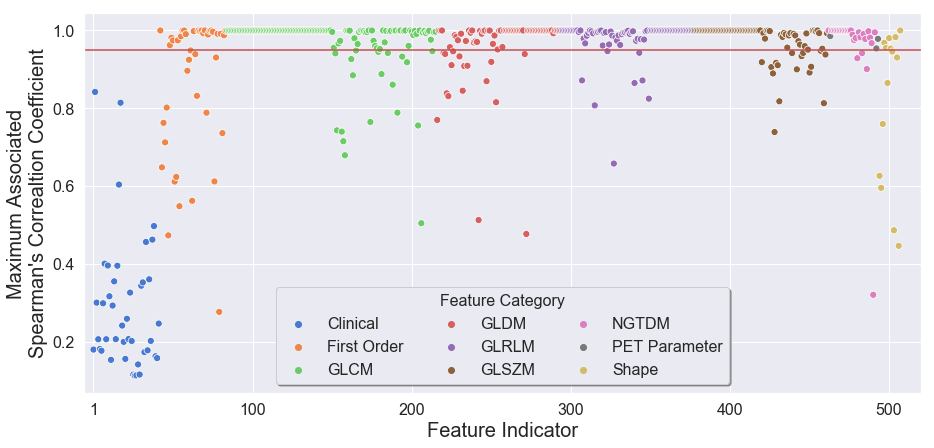

In [172]:
feature_cats = np.array(to_feature_categories(upper.columns))
sorted_cats_idx = np.argsort(feature_cats)

to_drop = np.where(sorted_cats_idx == max(sorted_cats_idx))
sorted_cats_idx = np.delete(sorted_cats_idx, to_drop)
feature_cats = np.delete(feature_cats, to_drop)

plt.figure(figsize=(15, 7))
sns.scatterplot(
    np.arange(np.size(max_feature_corr)), 
    max_feature_corr[sorted_cats_idx],
    hue=feature_cats[sorted_cats_idx],
    palette=sns.color_palette('muted', len(np.unique(feature_cats))),
    s=50
)
plt.legend(
    fontsize=16, title_fontsize=16, title='Feature Category', loc='upper center', 
    bbox_to_anchor=(0.5, 0.3), ncol=3, fancybox=True, shadow=True
)
plt.ylabel("Maximum Associated\nSpearman's Correaltion Coefficient", fontsize=20)
plt.xlabel('Feature Indicator', fontsize=20)
plt.xticks(np.linspace(0, 500, 6, dtype=int), np.linspace(1, 500, 6, dtype=int), fontsize=16)
plt.yticks(fontsize=16)
plt.xlim([-6, 520])
plt.axhline(y=0.95, c='r')
plt.savefig(
    './../../figures/compressing_feature_space/scc_radiom_feats.png', 
    bbox_inches='tight',
    dpi=100, 
)

In [316]:
sum(max_feature_corr > 0.95) / np.size(max_feature_corr) * 100

74.0234375

In [111]:
def prep_label(label):
    
    items = label.split('_')
    if len(items) == 5:
        if items[2] == 'firstorder':
            kind = 'First Order'
        else:
            kind = items[2].upper()
        if len(items[3]) > 20:
            return f'{items[0]} {kind}\n{items[3]}\n{items[4]}'
        return f'{items[0]} {kind} {items[3]} {items[4]}'
    elif len(items) == 4:
        if items[2] == 'firstorder':
            kind = 'First Order'
        else:
            kind = items[2].upper()
        if len(items[3]) > 20:
            return f'{items[0]} {kind}\n{items[3]}'
        return f'{items[0]} {kind} {items[3]}'
    else:
        raise ValueError('Unknown label format')

In [121]:
ct_samples_to_plot = [
    'CT_original_glcm_JointEntropy',
    'CT_original_glcm_SumEntropy',
    'CT_original_glcm_DifferenceVariance',
    'CT_original_glrlm_GrayLevelNonUniformity',
    'CT_original_glrlm_HighGrayLevelRunEmphasis',
    'CT_original_glrlm_ShortRunHighGrayLevelEmphasis',
    'CT_original_ngtdm_Contrast',
    'CT_original_ngtdm_Complexity',
    'CT_original_ngtdm_Strength'
]

In [122]:
pet_samples_to_plot = [
    'PET_original_glcm_JointEntropy',
    'PET_original_glcm_SumEntropy',
    'PET_original_glcm_DifferenceVariance',
    'PET_original_glrlm_GrayLevelNonUniformity',
    'PET_original_glrlm_HighGrayLevelRunEmphasis',
    'PET_original_glrlm_ShortRunHighGrayLevelEmphasis',
    'PET_original_ngtdm_Contrast',
    'PET_original_ngtdm_Complexity',
    'PET_original_ngtdm_Strength'
]

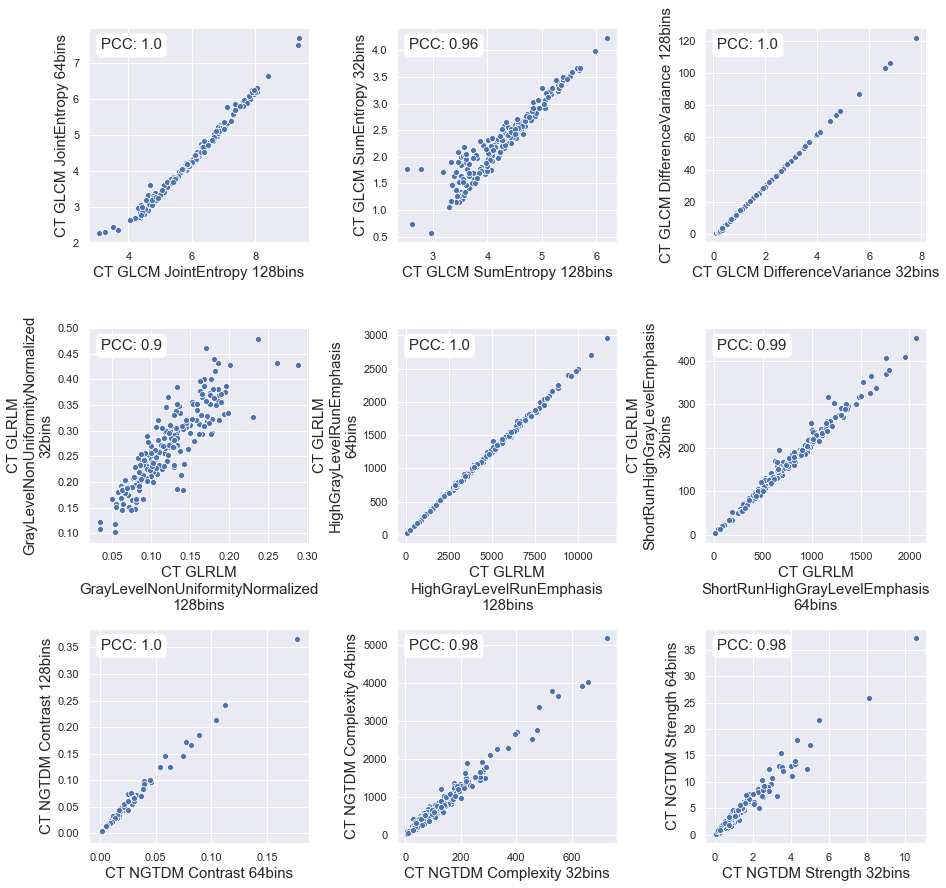

In [163]:
np.random.seed(seed=0)

fig, axes = plt.subplots(figsize=(15, 15), nrows=3, ncols=3)
for num, ct_sample in enumerate(ct_samples_to_plot):
    
    feats = X_orig.filter(regex=ct_sample)
    
    idx_a, idx_b = np.random.choice(3, size=2, replace=False)
    feat_a, feat_b = feats.iloc[:, idx_a], feats.iloc[:, idx_b]
    
    label_feat_a = prep_label(feats.columns[idx_a])
    label_feat_b = prep_label(feats.columns[idx_b])
    
    axis = axes.ravel()[num]
    sns.scatterplot(
        x=feat_a, 
        y=feat_b,
        ax=axis,
    )
    axis.set_ylabel(label_feat_b, fontsize=15)
    axis.set_xlabel(label_feat_a, fontsize=15)
    
    coeff = np.round(upper.loc[feats.columns[idx_b], feats.columns[idx_a]], 2)
    if np.isnan(coeff):
        coeff = np.round(upper.loc[feats.columns[idx_a], feats.columns[idx_b]], 2)
        
    # PCC = Pearson's Correaltion Coefficient.
    axis.annotate(
        f"PCC: {coeff}", 
        xy=(12, 190),
        xycoords='axes points',
        size=15, 
        ha='left', 
        va='bottom',
        bbox=dict(boxstyle='round', fc='w')
    )
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.savefig(
    './../../figures/compressing_feature_space/ct_corr_feature_examples.png', 
    bbox_inches='tight',
    dpi=100, 
)

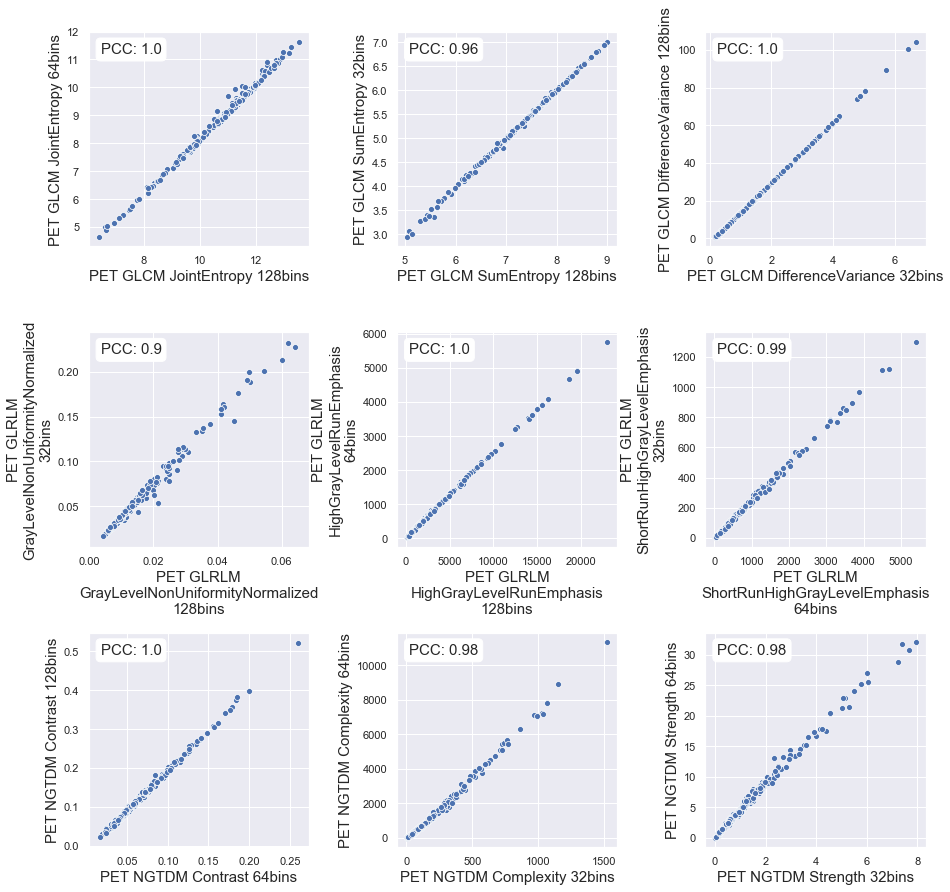

In [164]:
np.random.seed(seed=0)

fig, axes = plt.subplots(figsize=(15, 15), nrows=3, ncols=3)
for num, pet_sample in enumerate(pet_samples_to_plot):
    
    feats = X_orig.filter(regex=pet_sample)
    
    idx_a, idx_b = np.random.choice(3, size=2, replace=False)
    feat_a, feat_b = feats.iloc[:, idx_a], feats.iloc[:, idx_b]
    
    label_feat_a = prep_label(feats.columns[idx_a])
    label_feat_b = prep_label(feats.columns[idx_b])
    
    axis = axes.ravel()[num]
    sns.scatterplot(
        x=feat_a, 
        y=feat_b,
        ax=axis,
    )
    axis.set_ylabel(label_feat_b, fontsize=15)
    axis.set_xlabel(label_feat_a, fontsize=15)
    
    coeff = np.round(upper.loc[feats.columns[idx_b], feats.columns[idx_a]], 2)
    if np.isnan(coeff):
        coeff = np.round(upper.loc[feats.columns[idx_a], feats.columns[idx_b]], 2)
        
    # PCC = Pearson's Correaltion Coefficient.
    axis.annotate(
        f"PCC: {coeff}", 
        xy=(12, 190),
        xycoords='axes points',
        size=15, 
        ha='left', 
        va='bottom',
        bbox=dict(boxstyle='round', fc='w')
    )
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.savefig(
    './../../figures/compressing_feature_space/pet_corr_feature_examples.png', 
    bbox_inches='tight',
    dpi=100, 
)